# E1

Motion estimation is the process of determining motion vectors that describe the transformation from one 2D image to another; usually from adjacent frames in a video sequence.   
The methods for finding motion vectors can be categorised into pixel based methods ("direct") and feature based methods ("indirect").   
  
### Direct methods: 
Block-matching algorithm  
Phase correlation and frequency domain methods  
Pixel recursive algorithms  
Optical flow

In this exercise, I will use an algorithm of block-matching algorithm.  
The algorithm called Full Search.  

### BLOCK MATCHING ALGORITHMS   
  
  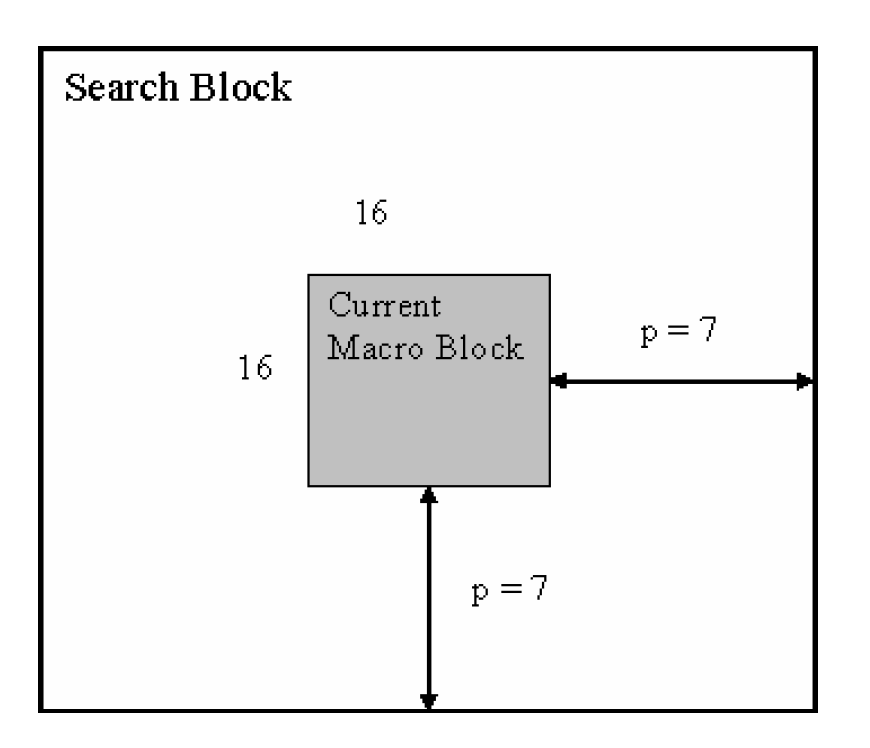
  
The underlying supposition behind motion estimation is that the patterns corresponding to objects and background in a frame of video sequence move within the frame to form corresponding objects on the subsequent frame. The idea behind block matching is to divide the current frame into a matrix of ‘macro blocks’ that are then compared with corresponding block and its adjacent neighbors in the previous frame to create a vector that stipulates the movement of a macro block from one location to another in the previous frame. This movement calculated for all the macro blocks comprising a frame, constitutes the motion estimated in the current frame. The search area for a good macro block match is constrained up to p pixels on all fours sides of the corresponding macro block in previous frame. This ‘p’ is called as the search parameter. Larger motions require a larger p, and the larger the search parameter the more computationally expensive the process of motion estimation becomes. Usually the macro block is taken as a square of side 16 pixels, and the search parameter p is 7 pixels.The idea is represented in the picture. The matching of one macro block with another is based on the output of a cost function. The macro block that results in the least cost is the one that matches the closest to current block. In this exercise, the cost I use is Mean Absolute Difference (MAD). 
$$MAD = \frac{1}{N^2}\sum_{i=0}^{N-1}\sum_{j=0}{N-1}|C_{ij} - R_{ij}|$$

### Full Search
This algorithm, also known as Full Search, is the most computationally expensive block matching algorithm of all. This algorithm calculates the cost function at each possible location in the search window. As a result of which it finds the best possible match and gives the highest PSNR amongst any block matching algorithm. Fast block matching algorithms try to achieve the same PSNR doing as little computation as possible. The obvious disadvantage to ES is that the larger the search window gets the more computations it requires.

In my code, the maximum response is the minimum MAD. The patch is the block in prior frame and local region is current block in letter frame

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [4]:
seq1 = {'I1': io.imread('data/image/seq1/frame1.png', as_grey=True),
        'I2': io.imread('data/image/seq1/frame3.png', as_grey=True),
        'U' : np.loadtxt('data/flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('data/flow/seq1/flow3.v', dtype='double', delimiter=',')}
rubic = {'I1':io.imread('data/rubic/rubic.0.png', as_grey=True),
        'I2':io.imread('data/rubic/rubic.5.png', as_grey=True)}
sphere= {'I1': io.imread('data/sphere/sphere.1.png', as_grey=True),
        'I2': io.imread('data/sphere/sphere.3.png', as_grey=True)}
I = np.random.rand(128, 128)
synth = {'I1': I[0:100, 0:100], 
         'I2': I[2:102, 2:102]}

In [16]:
def quiver(I, X, Y, U, V, scale):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    ax.imshow(I, cmap='gray')
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy',scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()

In [7]:
def FullSearch(I1, I2, mbSize,p):
    row = I1.shape[0]
    col = I2.shape[1]
    A = row * col
    B = mbSize**2
    C = A//B
    blockcenter = np.zeros([2,C])
    vectors = np.zeros((2,C))
    costs = np.ones((2*p+1, 2*p+1))*65537
    computations = 0
    mbcount = 1
    for i in range(0,row-mbSize,mbSize):
        for j in range(0,col-mbSize,mbSize):
            for m in range (-p,p):
                for n in range (-p,p):
                    refBlkVer = i+m
                    refBlkHor = j+n
                    if ((refBlkVer < 0 or refBlkVer + mbSize > row)or(refBlkHor <0 or refBlkHor + mbSize > col)):
                        continue
                    costs[m+p+1,n+p+1] = costFuncMAD(I2[i:i+mbSize,j:j+mbSize],
                                                     I1[refBlkVer:refBlkVer+mbSize,refBlkHor:refBlkHor+mbSize],
                                                     mbSize)
                    computations = computations + 1
            blockcenter[0,mbcount] = i+p
            blockcenter[1,mbcount] = j+p            
            dx, dy, min0 = minCost(costs)
            vectors[0,mbcount] = dy-p-1
            vectors[1,mbcount] = dx-p-1
            mbcount = mbcount + 1
            costs = np.ones((2*p + 1, 2*p +1)) * 65537
    motionVect = vectors
    FScomputations = computations/(mbcount)
    return motionVect, FScomputations, blockcenter

In [8]:
def costFuncMAD(currentBlk,refBlk, n):
    err = 0
    for i in range (n-2):
        for j in range(n-2):
            err = err + np.abs((currentBlk[i,j] - refBlk[i,j]))
    cost = err / (n*n)
    return cost 

In [9]:
def minCost (costs):
    row = costs.shape[0]
    col = costs.shape[1]
    min0 = 65537
    for i in range (row-1):
        for j in range (col-1):
            if (costs[i,j] < min0):
                min0 = costs[i,j]
                dx = j
                dy = i
    return dx, dy, min0

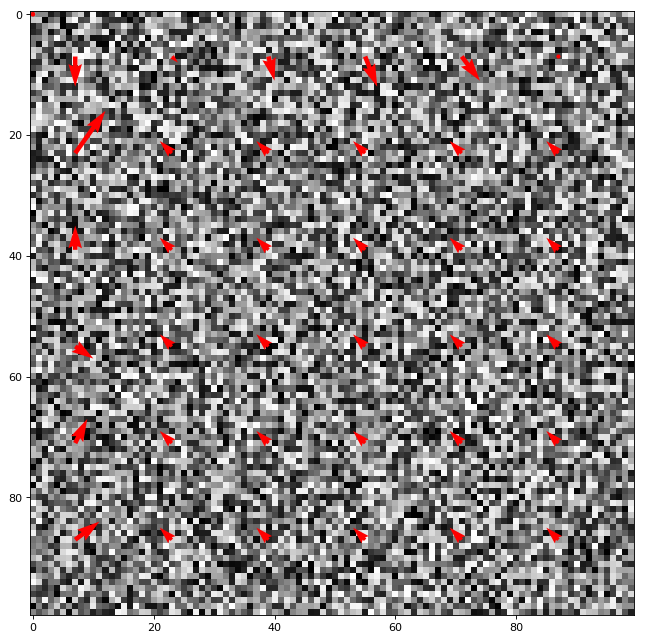

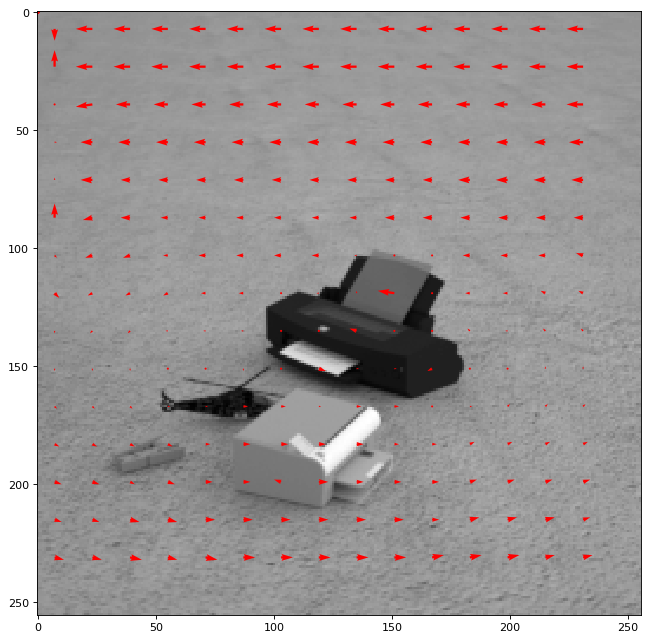

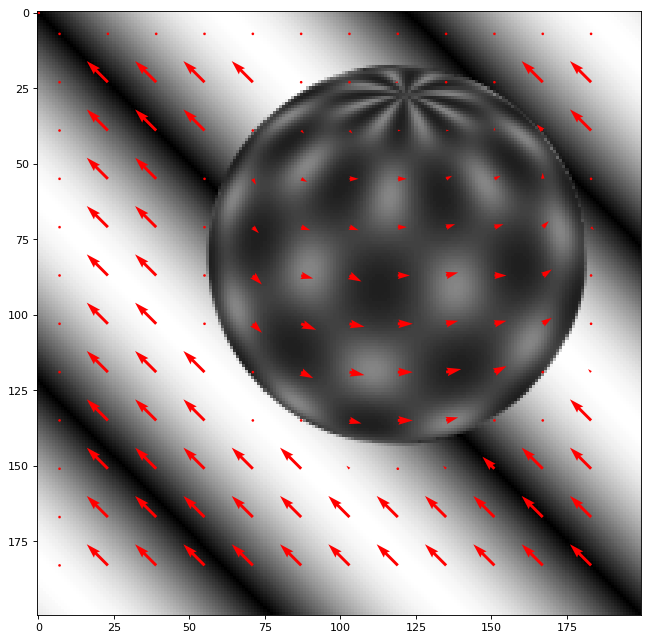

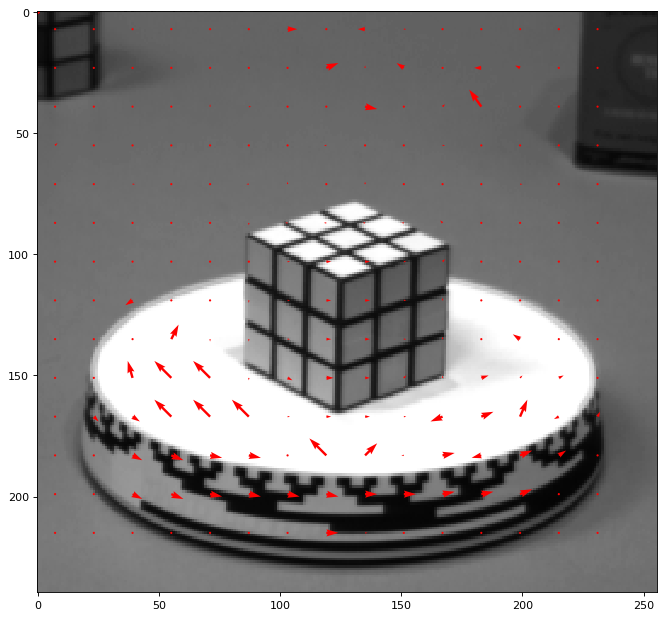

In [19]:
def Main(img_series):
    mbSize = 16
    p = 7
    motionVec, computations, blockcenter = FullSearch(img_series['I2'], img_series['I1'],mbSize,p)
    quiver(img_series['I1'],blockcenter[1,:],blockcenter[0,:],motionVec[1,:],motionVec[0,:],1)
    
Main(synth)
Main(seq1)
Main(sphere)
Main(rubic)

According to the results, I got the motion vectors, and motion vectors show the motion of frame. But different type pictures have different accuracies, I think the result in rubic is much better than the result in seq1 and sphere. In seq1 and sphere, there are lots of motion vectors of background. And results in seq1 and sphere, it is difficult to find the important parts. That is a shorts of making flow based on FullSearch. Because we have to match all points, so the feature points can not be prominent. In sephere, the motion vectors on the ball show the same direction, I think it is good.  
In rubic, we can find that, the prominent area is the rubik's cube and dial. Most motion vectors shows they move to same direction,but there are still some motion vectors show different direction. 

### Compare results of demo:  

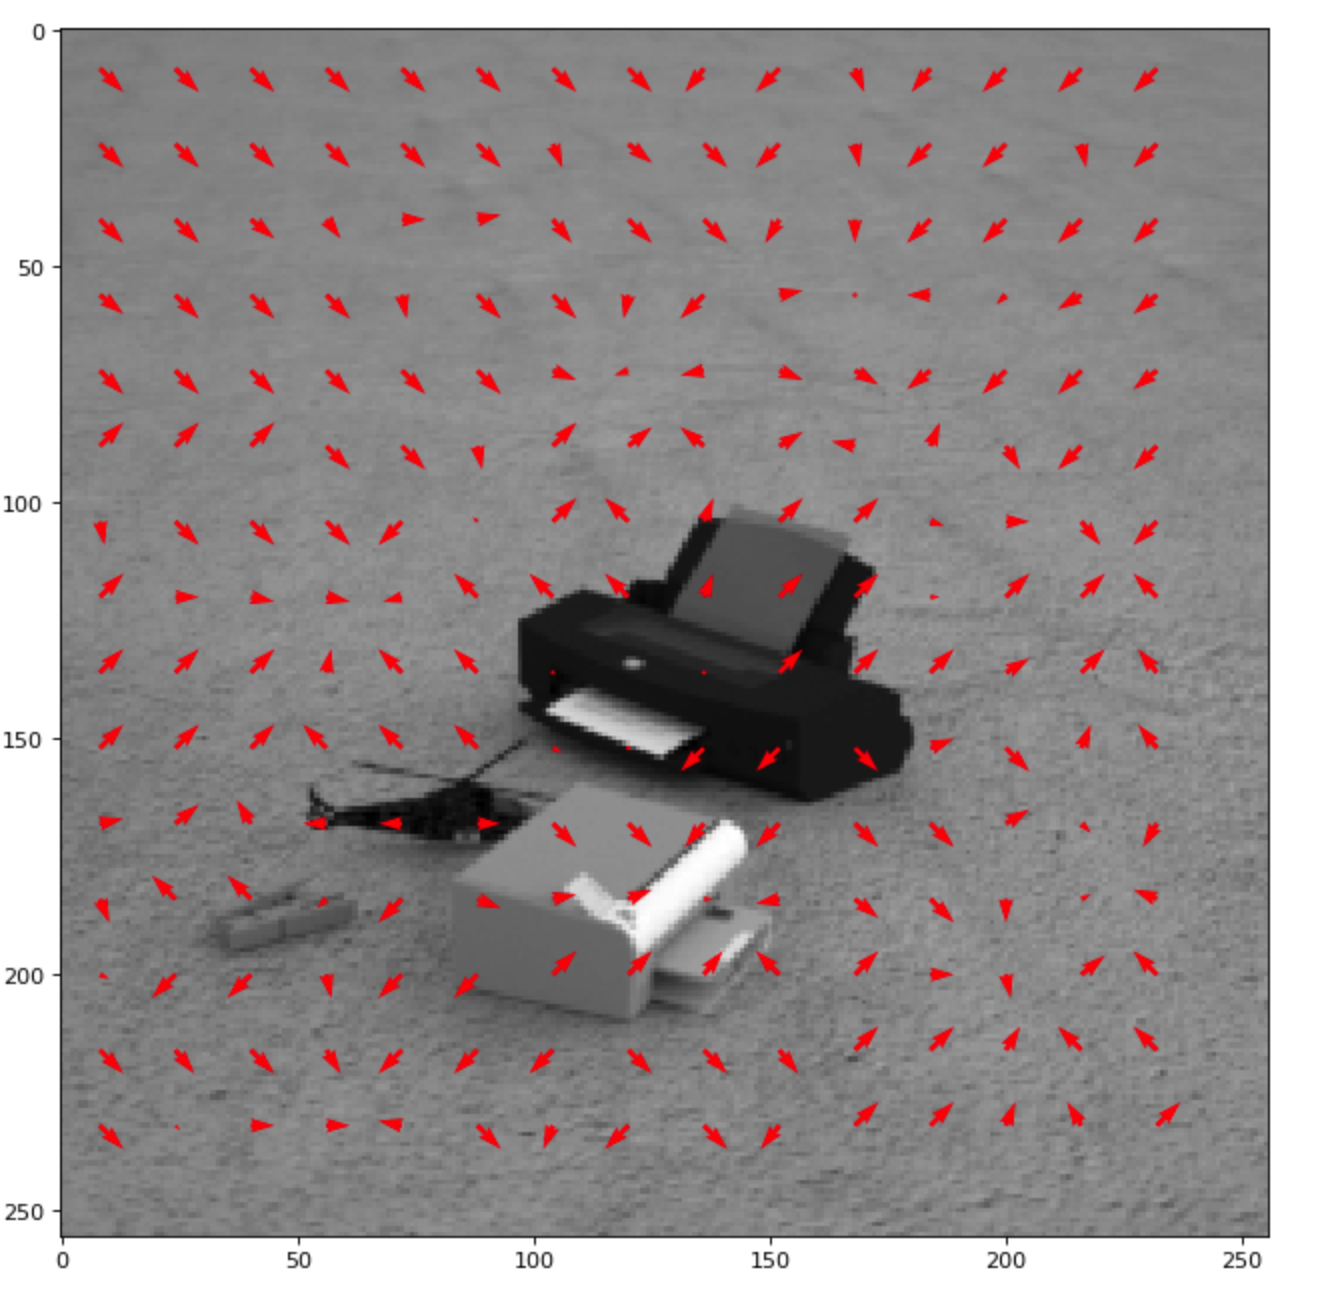

In [12]:
from IPython.display import Image 
Image(filename = "seq11.png",width = 400, height = 400)

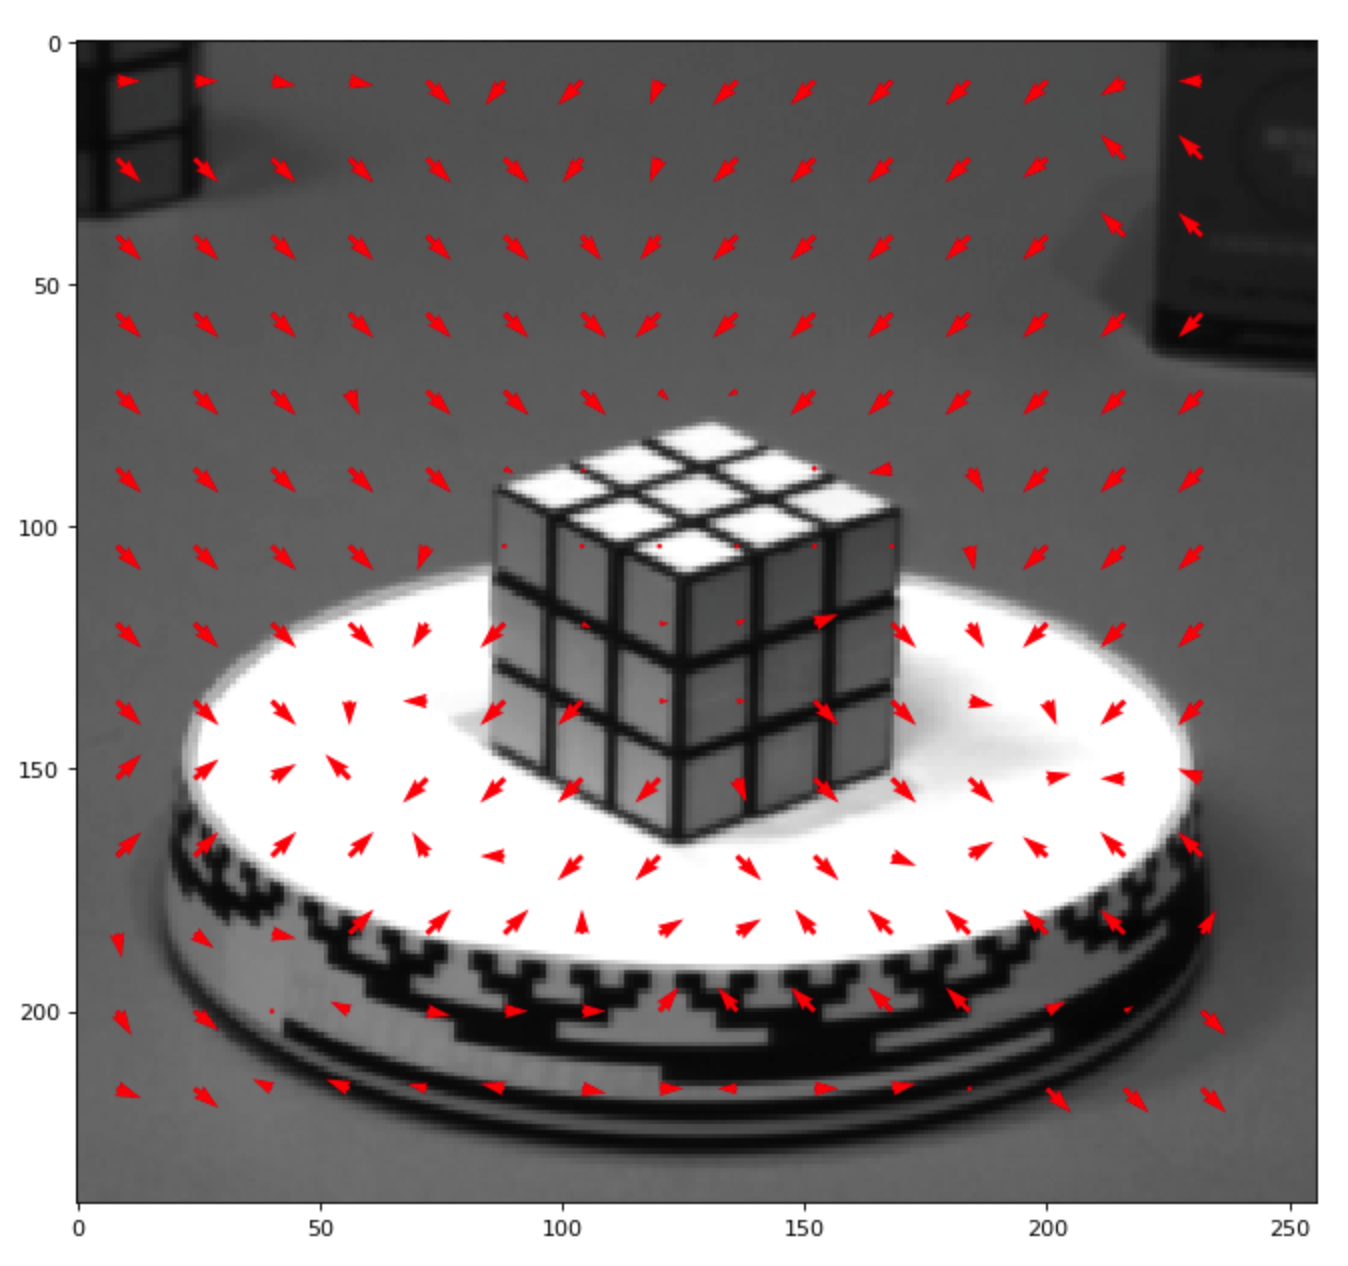

In [11]:
Image(filename = "rubic11.png",width = 400, height = 400)

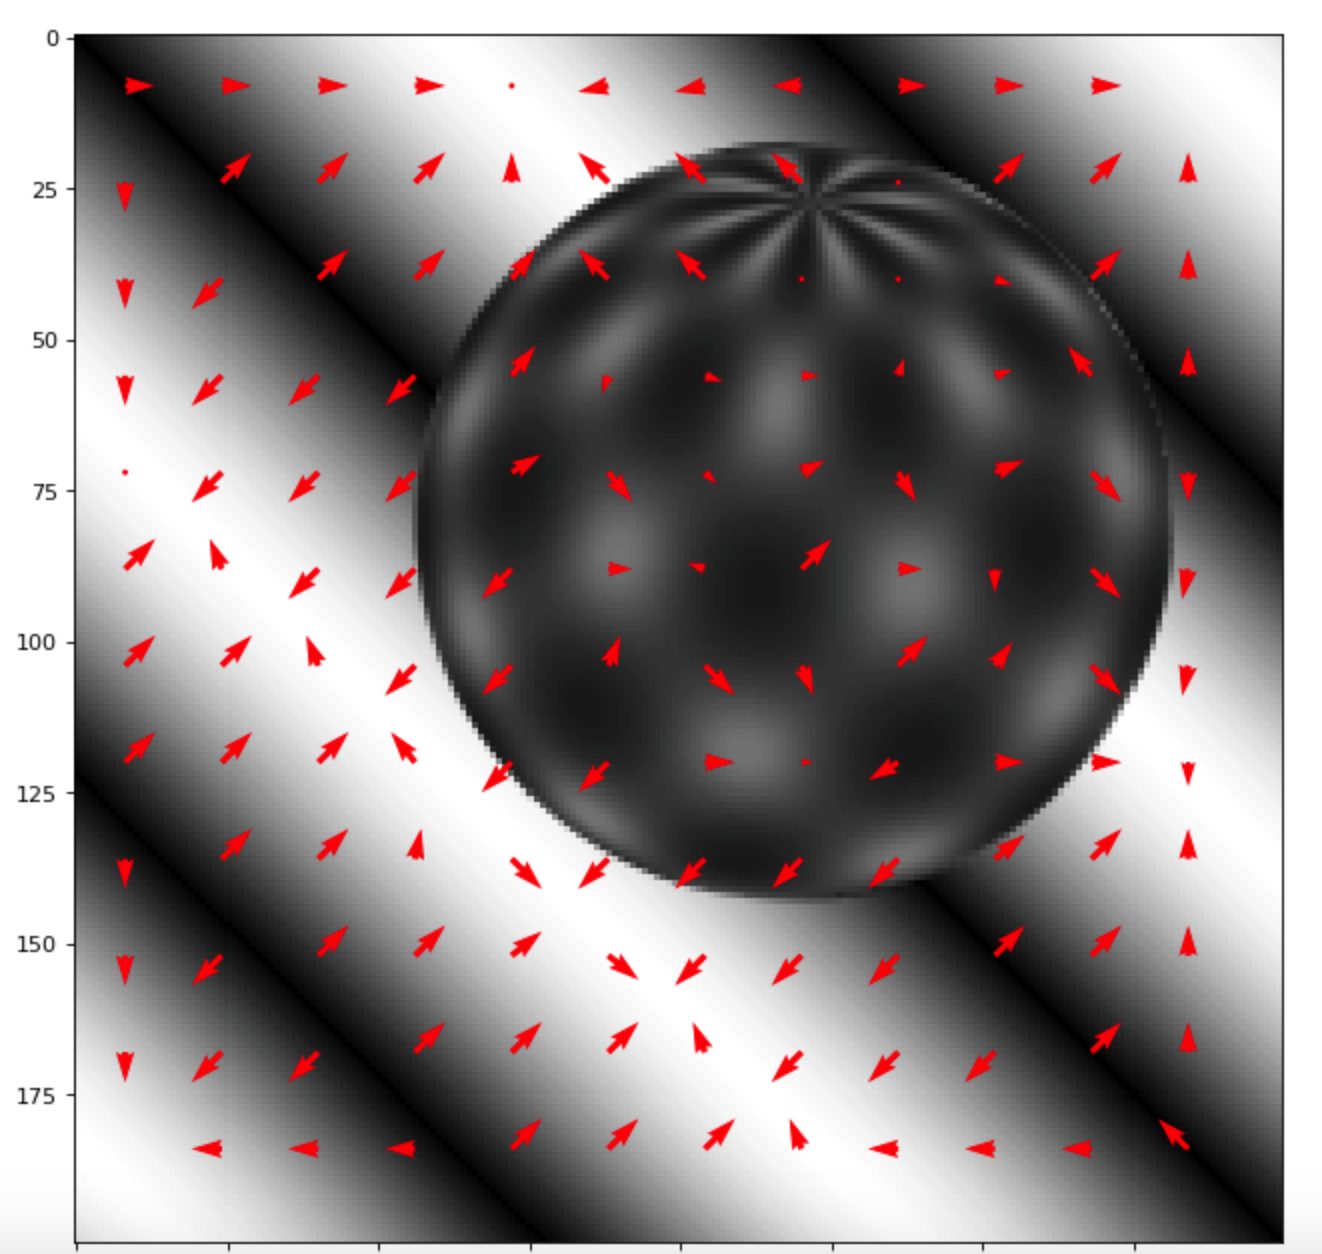

In [13]:
Image(filename = "sphere11.png",width = 400, height = 400)

In using demo's code, I have already changed the parameter to be same with my code. So, in the comparison, I think my method is quite better than demo. In results of demo, not only there are more motions vetors in background and in all pictures, but also we can not figure out the firection of motion of the frame.